# Imports

In [1]:
from collections import Counter, defaultdict
from tqdm.auto import tqdm

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline

from src.utils.loader import DataLoader
from src.utils.visualizer import ModelVisualizer
from src.utils.nlp import process_evaluation_set
from src.features.sentiment import SentimentFeatures
from src.features.concepts import ConceptExtractor
from src.models.classic import LinearSVMClassifier, LogisticRegressionClassifier, RbfSVMClassifier
from src.models.deep import BERTClassifier
from src.models.ensemble import EnsembleClassifier

import numpy as np

2026-01-04 14:01:05.514955: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/janek/Projekty/Sentiment/.venv/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


# Parameters

In [2]:
MAX_DF_RATIO = 0.3   # Upper threshold (stop-units)
MIN_TERM_FREQ = 10   # Lower threshold (noise)
STD_DEV_Z = 1.96     # 95% Confidence Interval for importance (1: 68%, 1.96: 95%, 2.576: 99.7%)
N_GRAM_RANGE = (1,3)
USE_CONCEPTS = False
NUMBER_CONCEPTS = 1000
LOWER_CONFIDENCE_THRESHOLD = 0.3
TRAIN_SIZE = 0.5
TEST_SIZE = 0.8 # % for test-validation split (after train split)

# Loading Data-Sets

In [3]:
loader = DataLoader()
train, val, test = loader.load_imdb(train_size=TRAIN_SIZE, test_size=TEST_SIZE)

Loading IMDb reviews...


I0000 00:00:1767531668.652597    4788 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3584 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
2026-01-04 14:01:08.868396: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:396] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


Cleaning 49582 reviews...


2026-01-04 14:01:16.780475: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


  0%|          | 0/49582 [00:00<?, ?it/s]

Loaded dataset with 24791 train, 4958 val and 19833 test samples.

--- TRAIN SET (Total: 24791 reviews) ---


,review,clean_review,clean_bow,sentiment
0,"I first saw this one when it was first shown, ...","I first saw this one when it was first shown, ...","i first saw this one when it was first shown, ...",1
1,I first watched Kindred in 1987 along with ano...,I first watched Kindred in 1987 along with ano...,i first watched kindred in 1987 along with ano...,0
2,Wasn't sure what to expect from this film. I l...,Wasn't sure what to expect from this film. I l...,was not sure what to expect from this film. i ...,1
3,"Someone(or, something thing..)is leaving punct...","Someone(or, something thing..)is leaving punct...","someone(or, something thing..)is leaving punct...",1
4,"I seldom see a film with such a cast, such a p...","I seldom see a film with such a cast, such a p...","i seldom see a film with such a cast, such a p...",0



--- VALIDATION SET (Total: 4958 reviews) ---


,review,clean_review,clean_bow,sentiment
0,"I have recently watched this film, and have de...","I have recently watched this film, and have de...","i have recently watched this film, and have de...",1
1,Where do I start? The box should have been eno...,Where do I start? The box should have been eno...,where do i start? the box should have been eno...,0
2,"How dare you? Adam Low, without apparent shame...","How dare you? Adam Low, without apparent shame...","how dare you? adam low, without apparent shame...",0
3,I was very excited to see a documentary on one...,I was very excited to see a documentary on one...,i was very excited to see a documentary on one...,1
4,Jeff Garlin's film is filled with heart and la...,Jeff Garlin's film is filled with heart and la...,jeff garlin's film is filled with heart and la...,1



--- TEST SET (Total: 19833 reviews) ---


,review,clean_review,clean_bow,sentiment
0,This film about secret government mind experim...,This film about secret government mind experim...,this film about secret government mind experim...,0
1,"While the movie has its flaws, it brings to li...","While the movie has its flaws, it brings to li...","while the movie has its flaws, it brings to li...",1
2,This has got to be one of the weakest plots in...,This has got to be one of the weakest plots in...,this has got to be one of the weakest plots in...,0
3,Police officer Dirk Hendricks (Jamie Bartlett)...,Police officer Dirk Hendricks (Jamie Bartlett)...,police officer dirk hendricks (jamie bartlett)...,1
4,My husband and I enjoy The DoodleBops as much ...,My husband and I enjoy The DoodleBops as much ...,my husband and i enjoy the doodlebops as much ...,1


Saved train set to data/IMDb/train.json
Saved val set to data/IMDb/val.json
Saved test set to data/IMDb/test.json


# Filtering-Out Words

## Most Common Words per Label (Stop Words)

Words that occur very frequently across **all labels** generally do not convey sentiment-specific information (e.g., *"this"*, *"the"*, *"is"*). Such terms provide little discriminatory power and can be treated as stop words.

Certain sentiment-related words may also fall into this category. For example, *"good"* appears in both positive and negative contexts and is often non-descriptive on its own (e.g., *"very good"* vs. *"not good"*). As a result, despite its apparent sentiment polarity, it may not meaningfully distinguish between labels and can also be excluded.

In [4]:
df_by_label = defaultdict(Counter)

for row in tqdm(train, desc="Calculating Document Frequencies"):
    units = DataLoader.get_ngrams(row['clean_bow'], ngram_range=N_GRAM_RANGE)
    df_by_label[row['sentiment']].update(set(units))

Calculating Document Frequencies:   0%|          | 0/24791 [00:00<?, ?it/s]

## Document Count per Label

We compute the number of documents associated with each sentiment label.  
This information is later used to normalize word frequencies and to define
label-specific document frequency thresholds.

In [5]:
n_docs_label = Counter(item['sentiment'] for item in train)
print("Document counts by label:", n_docs_label)

Document counts by label: Counter({1: 12442, 0: 12349})


## Intersection

Only words that are **most common in both groups are excluded**. Otherwise, these words are very usefull to distinguish between the labels.

In [6]:
stop_sets = []

for label in df_by_label:
    threshold = n_docs_label[label] * MAX_DF_RATIO
    stop_sets.append({u for u, count in tqdm(df_by_label[label].items(), desc=f"Finding most common words for label {label}") if count > threshold})

stop_units = set.intersection(*stop_sets)
print(f"Identified {len(stop_units)} stop-units.")

Finding most common words for label 1:   0%|          | 0/2852340 [00:00<?, ?it/s]

Finding most common words for label 0:   0%|          | 0/2714661 [00:00<?, ?it/s]

Identified 79 stop-units.


## Least Common Words (Rare-tokens)

These are words that appear only a few times in the dataset. They often include misspellings, proper names, non-existent words, or words in foreign languages (e.g., German).  

In [7]:
tf_counts = Counter()

for item in tqdm(train, desc="Counting units"):
    units = DataLoader.get_ngrams(item['clean_bow'], ngram_range=N_GRAM_RANGE)
    for u in units:
        if u not in stop_units:
            tf_counts[u] += 1

# Filter for units that appear at least MIN_TERM_FREQ times
unique_units = {u for u, count in tqdm(tf_counts.items(), desc="Filtering units") if count >= MIN_TERM_FREQ}
print(f"Total unique units after filtering: {len(unique_units)}")

Counting units:   0%|          | 0/24791 [00:00<?, ?it/s]

Filtering units:   0%|          | 0/4914611 [00:00<?, ?it/s]

Total unique units after filtering: 150700


# Concepts
Words grouped with embeddings using k-means

In [8]:
if USE_CONCEPTS:
    print("Extracting semantic concepts using SBERT + Clustering...")
    extractor = ConceptExtractor()
    concept_results = extractor.train_concepts(unique_units, n_clusters=NUMBER_CONCEPTS)
    train_map = concept_results['unit_to_cluster']
    cluster_centers = concept_results['cluster_centers']
else:
    print("Using standard Bag-of-Words (Identity Mapping)...")
    train_map = {unit: i for i, unit in enumerate(unique_units)}
    extractor = None

Using standard Bag-of-Words (Identity Mapping)...


In [9]:
for row in tqdm(train, desc="Mapping Train Units"):
    units = DataLoader.get_ngrams(row['clean_bow'], ngram_range=N_GRAM_RANGE)
    # Map to integer IDs and store
    row['concept_ids'] = [train_map[u] for u in units if u in train_map]

Mapping Train Units:   0%|          | 0/24791 [00:00<?, ?it/s]

# Feature selection

In [10]:
# 1. Fit Sentiment Statistics
sf = SentimentFeatures()
sf.fit([item['concept_ids'] for item in train], [item['sentiment'] for item in train])

# 2. Extract Significant Features (Z-Score filtering)
top_pos_ids = set(sf.logodds_per_class[1][sf.logodds_per_class[1]['zscore'] > STD_DEV_Z]['concept'])
top_neg_ids = set(sf.logodds_per_class[0][sf.logodds_per_class[0]['zscore'] > STD_DEV_Z]['concept'])
important_set = top_pos_ids | top_neg_ids

total_concepts = len(sf.concept_list)
important_count = len(important_set)

# 3. Number of "not important" concepts
not_important_count = total_concepts - important_count

print(f"Total concepts processed: {total_concepts}")
print(f"Important concepts (kept): {important_count}")
print(f"Not important concepts (discarded): {not_important_count}")

discard_ratio = (not_important_count / total_concepts) * 100
print(f"Reduction rate: {discard_ratio:.2f}%")

# 4. Filter only important indices
for item in tqdm(train, desc="Filtering Important IDs"):
    item['important_ids'] = [c for c in item['concept_ids'] if c in important_set]

Total concepts processed: 150700
Important concepts (kept): 39742
Not important concepts (discarded): 110958
Reduction rate: 73.63%


Filtering Important IDs:   0%|          | 0/24791 [00:00<?, ?it/s]

In [11]:
process_evaluation_set(
    val, "Validation", train_map, stop_units, MIN_TERM_FREQ, 
    important_set=important_set, n_gram_range=N_GRAM_RANGE,
    cluster_centers=concept_results['cluster_centers'] if USE_CONCEPTS else None,
    extractor_obj=extractor if USE_CONCEPTS else None
)

process_evaluation_set(
    test, "Test", train_map, stop_units, MIN_TERM_FREQ, 
    important_set=important_set, n_gram_range=N_GRAM_RANGE,
    cluster_centers=concept_results['cluster_centers'] if USE_CONCEPTS else None,
    extractor_obj=extractor if USE_CONCEPTS else None
)


1/3: Scanning Validation for local rare tokens...


Scanning Validation:   0%|          | 0/4958 [00:00<?, ?it/s]

2/3: Mapping 112 unknown units (0.3% of significant) for Validation...
3/3: Mapping and Filtering Validation...


Processing Validation:   0%|          | 0/4958 [00:00<?, ?it/s]


--- Mapping Verification for Validation ---
Significant Vocabulary Discovery:
  - Total Significant Units: 32476
  - Known (from train):     32364
  - Unknown (New):          112 (0.3%)

Token-Level Impact (Instances in Text):
  - Units from Train Mapping:   1003919 (100.0%)
  - Units from Unknown Mapping: 0 (0.0%)
  - Successfully re-mapped:     0/112 unique unknown tokens.

1/3: Scanning Test for local rare tokens...


Scanning Test:   0%|          | 0/19833 [00:00<?, ?it/s]

2/3: Mapping 13708 unknown units (11.2% of significant) for Test...
3/3: Mapping and Filtering Test...


Processing Test:   0%|          | 0/19833 [00:00<?, ?it/s]


--- Mapping Verification for Test ---
Significant Vocabulary Discovery:
  - Total Significant Units: 122377
  - Known (from train):     108669
  - Unknown (New):          13708 (11.2%)

Token-Level Impact (Instances in Text):
  - Units from Train Mapping:   4300943 (100.0%)
  - Units from Unknown Mapping: 0 (0.0%)
  - Successfully re-mapped:     0/13708 unique unknown tokens.


In [12]:
ModelVisualizer.display_dataset_previews(train, val, test)


--- TRAIN SET (Total: 24791 reviews) ---


,clean_review,clean_bow,sentiment,concept_ids,important_ids
0,"I first saw this one when it was first shown, ...","i first saw this one when it was first shown, ...",1,"[59600, 110822, 59600, 23999, 113953, 36887, 7...","[59600, 110822, 59600, 23999, 113953, 36887, 1..."
1,I first watched Kindred in 1987 along with ano...,i first watched kindred in 1987 along with ano...,0,"[59600, 54023, 57084, 95705, 42751, 144309, 14...","[59600, 42751, 142054, 73344, 102194, 14046, 5..."
2,Wasn't sure what to expect from this film. I l...,was not sure what to expect from this film. i ...,1,"[146752, 86280, 34638, 85334, 47450, 31734, 95...","[146752, 34638, 85334, 47450, 31734, 95781, 87..."
3,"Someone(or, something thing..)is leaving punct...","someone(or, something thing..)is leaving punct...",1,"[21096, 91474, 119776, 80007, 71135, 16983, 26...","[21096, 91474, 119776, 26862, 128149, 12976, 7..."
4,"I seldom see a film with such a cast, such a p...","i seldom see a film with such a cast, such a p...",0,"[127984, 77715, 30558, 77715, 43722, 67341, 14...","[127984, 30558, 43722, 67341, 146342, 122410, ..."



--- VALIDATION SET (Total: 4958 reviews) ---


,clean_review,clean_bow,sentiment,important_ids
0,"I have recently watched this film, and have de...","i have recently watched this film, and have de...",1,"[145655, 27719, 141667, 83782, 128060, 134850,..."
1,Where do I start? The box should have been eno...,where do i start? the box should have been eno...,0,"[148721, 32060, 61902, 100664, 90801, 6162, 90..."
2,"How dare you? Adam Low, without apparent shame...","how dare you? adam low, without apparent shame...",0,"[136426, 32060, 73128, 61917, 73561, 111037, 1..."
3,I was very excited to see a documentary on one...,i was very excited to see a documentary on one...,1,"[14216, 119617, 97630, 74852, 143580, 134239, ..."
4,Jeff Garlin's film is filled with heart and la...,jeff garlin's film is filled with heart and la...,1,"[100914, 79686, 10367, 81877, 49666, 126206, 1..."



--- TEST SET (Total: 19833 reviews) ---


,clean_review,clean_bow,sentiment,important_ids
0,This film about secret government mind experim...,this film about secret government mind experim...,0,"[108413, 148355, 33392, 88238, 86691, 113151, ..."
1,"While the movie has its flaws, it brings to li...","while the movie has its flaws, it brings to li...",1,"[69723, 122130, 8131, 8015, 77498, 40775, 2564..."
2,This has got to be one of the weakest plots in...,this has got to be one of the weakest plots in...,0,"[107951, 134943, 134850, 76158, 140029, 1643, ..."
3,Police officer Dirk Hendricks (Jamie Bartlett)...,police officer dirk hendricks (jamie bartlett)...,1,"[3560, 106067, 36242, 73344, 17600, 117513, 87..."
4,My husband and I enjoy The DoodleBops as much ...,my husband and i enjoy the doodlebops as much ...,1,"[76061, 22638, 141318, 46495, 82003, 80396, 56..."


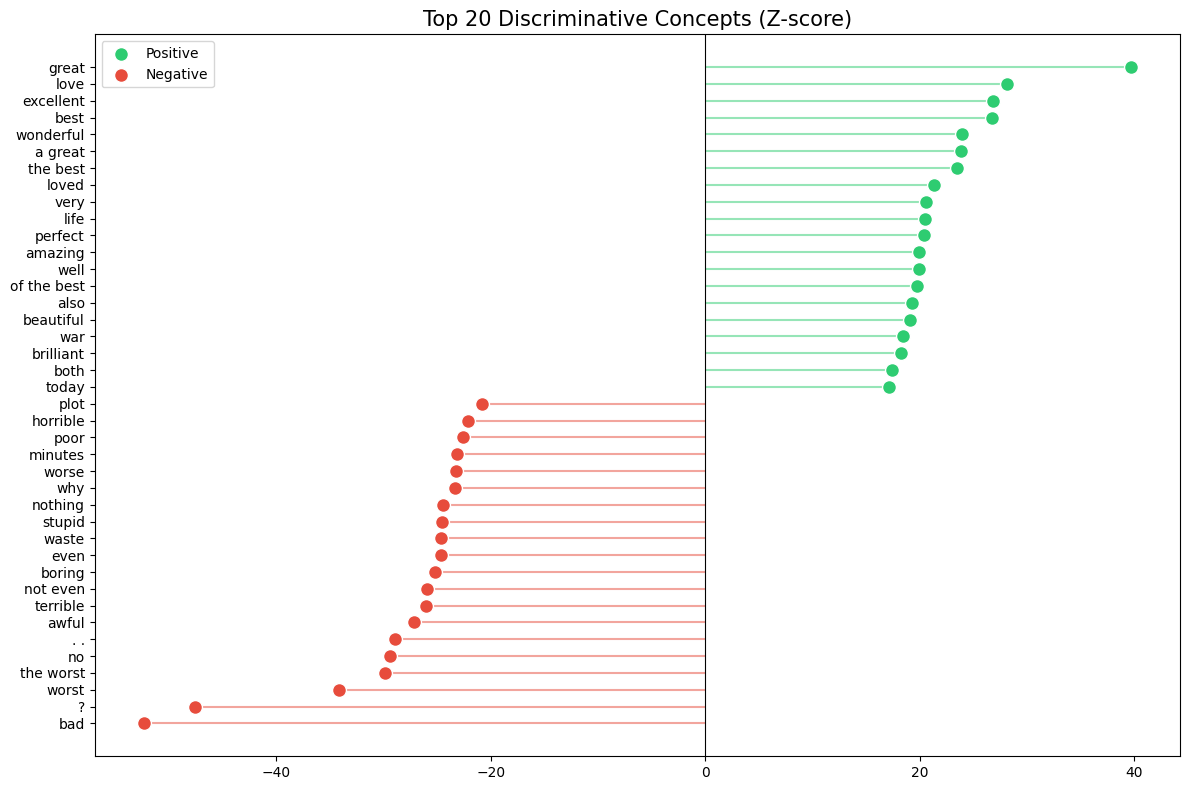

Building WordCloud clusters:   0%|          | 0/24791 [00:00<?, ?it/s]

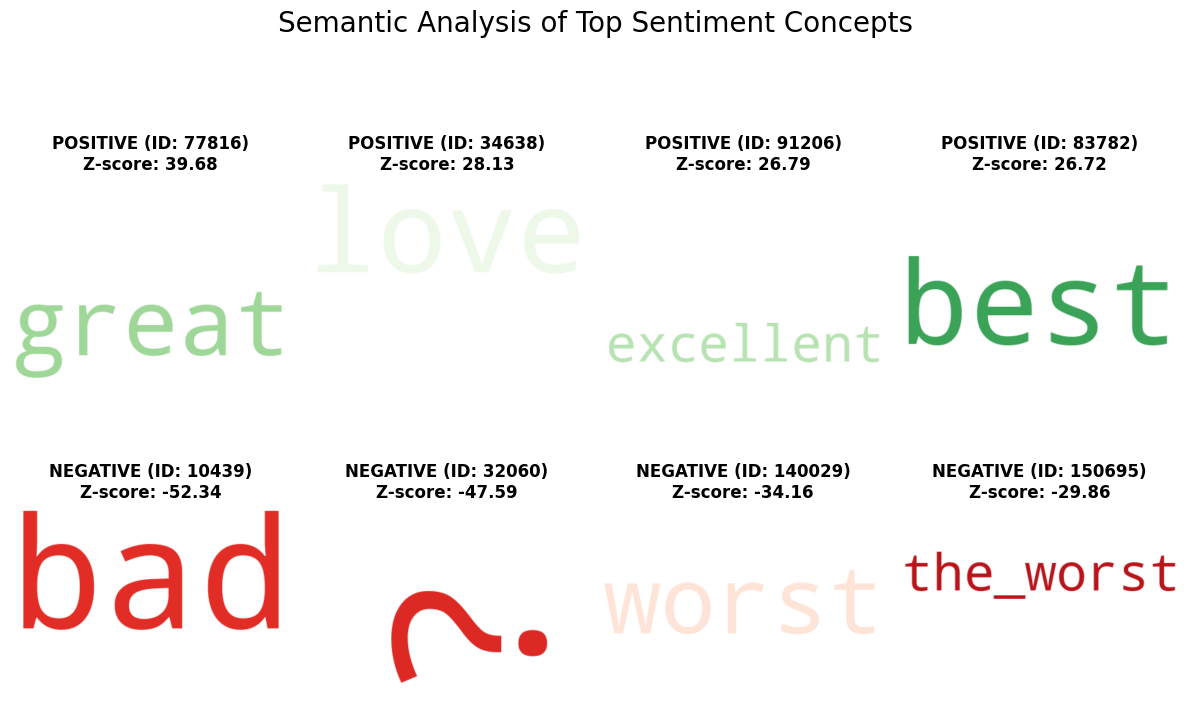

In [13]:
concept_units = {i: u for u, i in train_map.items()}
ModelVisualizer.plot_top_concepts(sf, concept_units, top_n=20)
ModelVisualizer.plot_sentiment_wordclouds(train, train_map, unique_units, sf, n_gram_range=N_GRAM_RANGE)

In [14]:
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=lambda x: x, lowercase=False, token_pattern=None)),
    ('tfidf', TfidfTransformer()),
])

X_train = pipeline.fit_transform(item['important_ids'] for item in train)
X_test = pipeline.transform(item['important_ids'] for item in test)
X_val = pipeline.transform(item['important_ids'] for item in val)

Classic model saved to: data/svm.joblib


## SVM_BOC Evaluation (Train)

**Accuracy:** 0.9952

,precision,recall,f1-score,support
0,0.99530,0.99498,0.99514,12349
1,0.99502,0.99534,0.99518,12442
accuracy,0.99516,0.99516,0.99516,0
macro avg,0.99516,0.99516,0.99516,24791
weighted avg,0.99516,0.99516,0.99516,24791


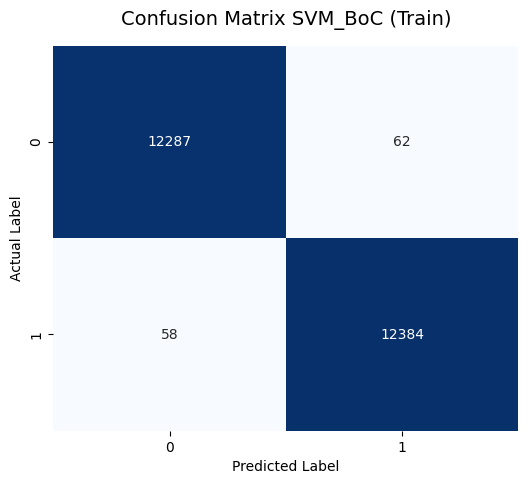

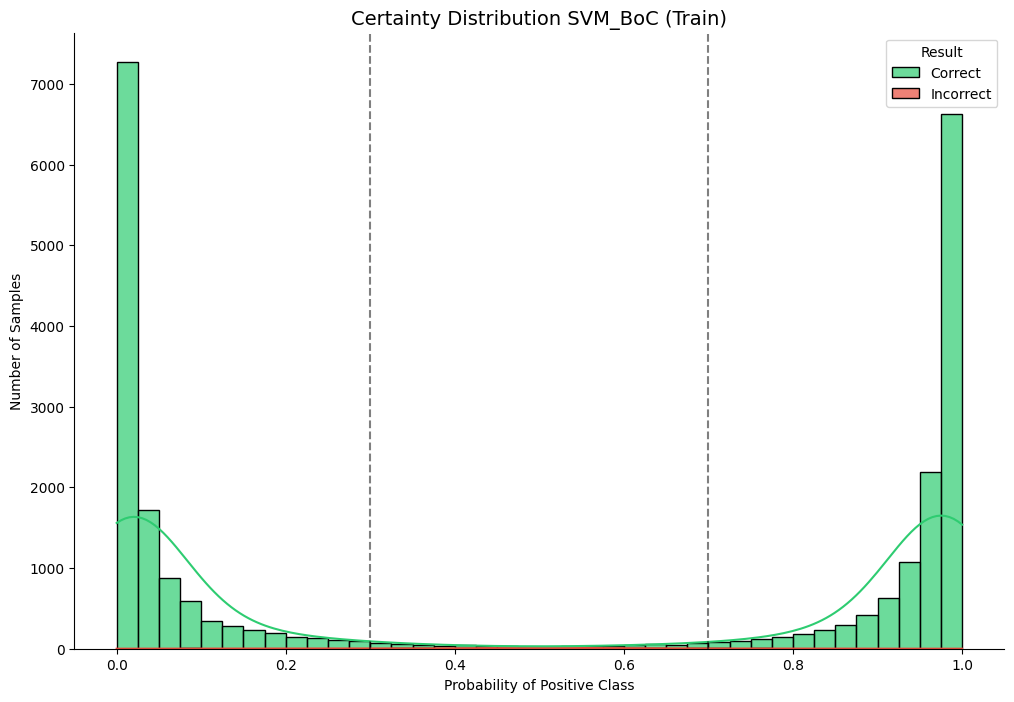

,Number_Samples,Correct,Accuracy (%),Coverage (%)
Overall,24791,24671,99.52,100.00
Certain Positive,12110,12098,99.90,48.85
Certain Negative,11993,11982,99.91,48.38
Uncertain,688,591,85.90,2.78


## SVM_BOC Evaluation (Test)

**Accuracy:** 0.9125

,precision,recall,f1-score,support
0,0.91619,0.90738,0.91176,9879
1,0.90895,0.91762,0.91326,9954
accuracy,0.91252,0.91252,0.91252,0
macro avg,0.91257,0.91250,0.91251,19833
weighted avg,0.91255,0.91252,0.91252,19833


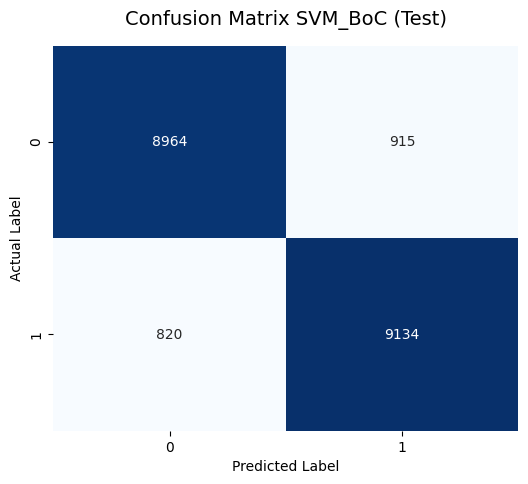

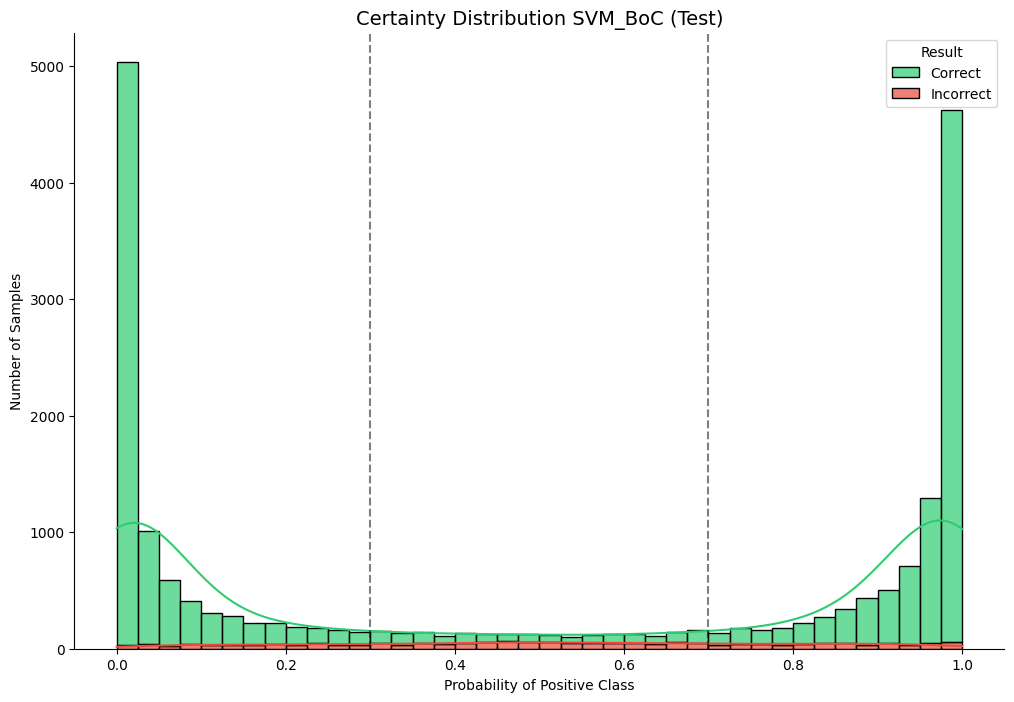

,Number_Samples,Correct,Accuracy (%),Coverage (%)
Overall,19833,18098,91.25,100.00
Certain Positive,9045,8534,94.35,45.61
Certain Negative,8738,8314,95.15,44.06
Uncertain,2050,1250,60.98,10.34


In [35]:
svm_model = LinearSVMClassifier(name="SVM_BoC")
svm_model.train(X_train, [item['sentiment'] for item in train])
svm_model.save("data/svm")

svm_probs_train, svm_preds_train = svm_model.evaluate(X_train, [item['sentiment'] for item in train], lower_threshold=LOWER_CONFIDENCE_THRESHOLD, name="Train")
svm_probs_test, svm_preds_test = svm_model.evaluate(X_test, [item['sentiment'] for item in test], lower_threshold=LOWER_CONFIDENCE_THRESHOLD, name="Test")

In [16]:
for i, item in enumerate(train):
    item['pred'] = svm_preds_train[i]
    item['prob'] = svm_probs_train[i]

ModelVisualizer.display_extreme_errors(train)
ModelVisualizer.display_uncertain_errors(train)


--- Top 5 'Confident' Positive Errors (Sure it was 1, actually 0) ---


,clean_review,sentiment,pred,prob
0,this is a great movie. I love the series on tv...,0,1,0.982885
1,I love the episode where Jim becomes the Green...,0,1,0.866168
2,'Major Payne' is a film about a major who make...,0,1,0.816601
3,"I went to see this 3 nights ago here in Cork, ...",0,1,0.782235
4,I am a back Batman movie and TV fan. I loved t...,0,1,0.765568



--- Top 5 'Confident' Negative Errors (Sure it was 0, actually 1) ---


,clean_review,sentiment,pred,prob
0,Like the gentle giants that make up the latter...,1,0,0.131451
1,**SPOILERS AHEAD** It is really unfortunate th...,1,0,0.096437
2,This low-budget erotic thriller that has some ...,1,0,0.086024
3,This flick is sterling example of the state of...,1,0,0.080975
4,This was Laurel and Hardy's last silent film f...,1,0,0.072828



--- Top 10 Most Uncertain Reviews (Prob near 0.5) ---


,clean_review,sentiment,pred,prob,uncertainty_score
0,STAR RATING: ***** The Works **** Just Misses ...,1,0,0.499736,0.000264
1,"Pulling in 2.6 million viewers, one has to won...",1,0,0.497272,0.002728
2,Working-class romantic drama from director Mar...,1,0,0.495913,0.004087
3,This must be the dumbest movie I've ever seen ...,1,0,0.494833,0.005167
4,"I'm a fan of Columbo, especially on a rainy Sa...",0,1,0.505339,0.005339
5,I honestly thought this movie was going to be ...,0,1,0.505426,0.005426
6,Hollywood has turned the Mafia in to a product...,1,0,0.493529,0.006471
7,Bridges of madison county is a better made ver...,0,1,0.507655,0.007655
8,"I appreciated the photography, the textures, t...",1,0,0.491367,0.008633
9,"I'm not here to tell you ""Armored"" is Kubricki...",1,0,0.489948,0.010052


In [17]:
for i, item in enumerate(test):
    item['pred'] = svm_preds_test[i]
    item['prob'] = svm_probs_test[i]

ModelVisualizer.display_extreme_errors(test)
ModelVisualizer.display_uncertain_errors(test)


--- Top 5 'Confident' Positive Errors (Sure it was 1, actually 0) ---


,clean_review,sentiment,pred,prob
0,'Ernest Saves Christmas' is comedian Ernest's ...,0,1,0.999665
1,"Lois Weber's film ""Hypocrites"" was and still k...",0,1,0.998925
2,"Why does the poster & artwork say ""Clubbed is ...",0,1,0.997533
3,"In 17th Century Japan, there lived a samurai w...",0,1,0.996720
4,I have an affection for these twists on Britis...,0,1,0.996356



--- Top 5 'Confident' Negative Errors (Sure it was 0, actually 1) ---


,clean_review,sentiment,pred,prob
0,If the creators of this film had made any atte...,1,0,0.005588
1,"If, unlike some of the commenters here, you ar...",1,0,0.005377
2,What is your freaking problem? Do you have not...,1,0,0.004272
3,This movie has everything that makes a bad mov...,1,0,0.002707
4,This movie is stuffed full of stock Horror mov...,1,0,0.000729



--- Top 10 Most Uncertain Reviews (Prob near 0.5) ---


,clean_review,sentiment,pred,prob,uncertainty_score
0,"About 15 minutes in, my wife was already wanti...",0,1,0.500007,0.000007
1,It's telling that as of the entry of this comm...,0,1,0.500096,0.000096
2,"First of all, when people hear 'GUY RITCHIE', ...",1,0,0.499790,0.000210
3,The truth is that a film based on a Harold Rob...,0,1,0.500338,0.000338
4,many people have said that this movie was not ...,1,0,0.499491,0.000509
5,Another turgid action/adventure flick from the...,0,1,0.500533,0.000533
6,"Hey people, what's up. It's me man, the one an...",1,0,0.499460,0.000540
7,I turned over to this film in the middle of th...,1,0,0.498334,0.001666
8,This is a cute little horror spoof/comedy feat...,1,0,0.498087,0.001913
9,Anyone who loves the Rheostatics' music is goi...,1,0,0.497836,0.002164


In [ ]:
if USE_CONCEPTS and NUMBER_CONCEPTS <= 500 and len(train) < 500:
    rbf_model = RbfSVMClassifier(name="RBF_SVM_BoC")
    rbf_model.train(X_train, [item['sentiment'] for item in train])
    rbf_probs_train, rbf_preds_train = rbf_model.evaluate(X_train, [item['sentiment'] for item in train], lower_threshold=LOWER_CONFIDENCE_THRESHOLD, name="Train")
    rbf_probs_test, rbf_preds_test = rbf_model.evaluate(X_test, [item['sentiment'] for item in test], lower_threshold=LOWER_CONFIDENCE_THRESHOLD, name="Test")

    for i, item in enumerate(train):
        item['pred'] = rbf_preds_train[i]
        item['prob'] = rbf_probs_train[i]

    ModelVisualizer.display_extreme_errors(train)
    ModelVisualizer.display_uncertain_errors(train)

    for i, item in enumerate(test):
        item['pred'] = rbf_preds_test[i]
        item['prob'] = rbf_probs_test[i]

    ModelVisualizer.display_extreme_errors(test)
    ModelVisualizer.display_uncertain_errors(test)
else:
    print("RBF SVM skipped due to too long training (N^3).")

RBF SVM skipped due to too long training (N^3).


## LOGREG_BOC Evaluation (Train)

**Accuracy:** 0.9512

,precision,recall,f1-score,support
0,0.95723,0.94429,0.95072,12349
1,0.94544,0.95813,0.95174,12442
accuracy,0.95123,0.95123,0.95123,0
macro avg,0.95133,0.95121,0.95123,24791
weighted avg,0.95131,0.95123,0.95123,24791


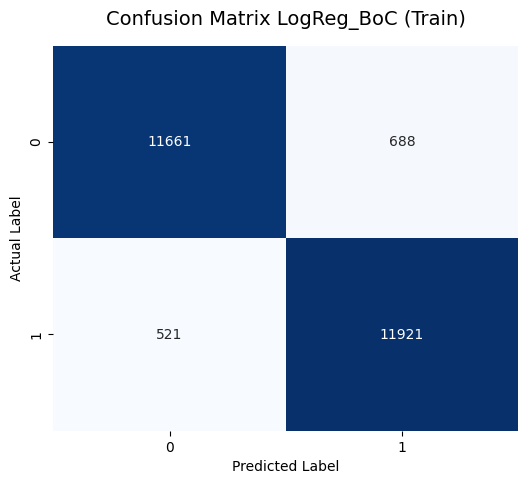

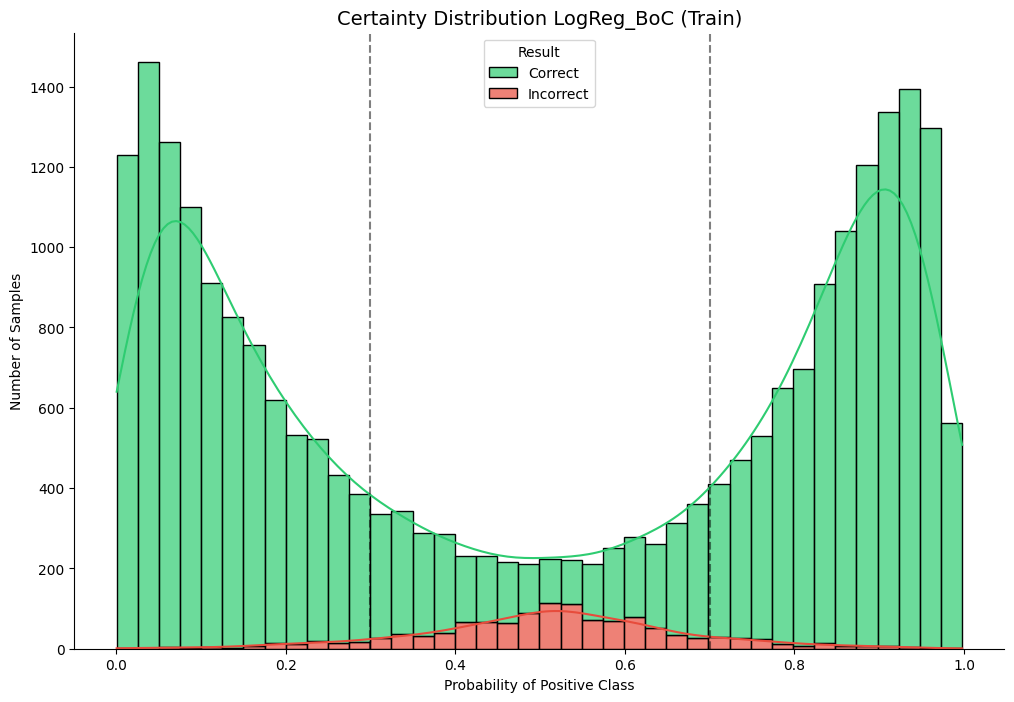

,Number_Samples,Correct,Accuracy (%),Coverage (%)
Overall,24791,23582,95.12,100.00
Certain Positive,10476,10341,98.71,42.26
Certain Negative,10037,9938,99.01,40.49
Uncertain,4278,3303,77.21,17.26


## LOGREG_BOC Evaluation (Test)

**Accuracy:** 0.9078

,precision,recall,f1-score,support
0,0.91901,0.89361,0.90613,9879
1,0.89723,0.92184,0.90937,9954
accuracy,0.90778,0.90778,0.90778,0
macro avg,0.90812,0.90773,0.90775,19833
weighted avg,0.90808,0.90778,0.90776,19833


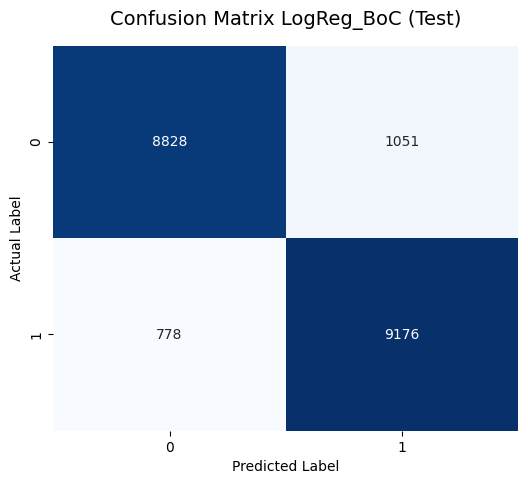

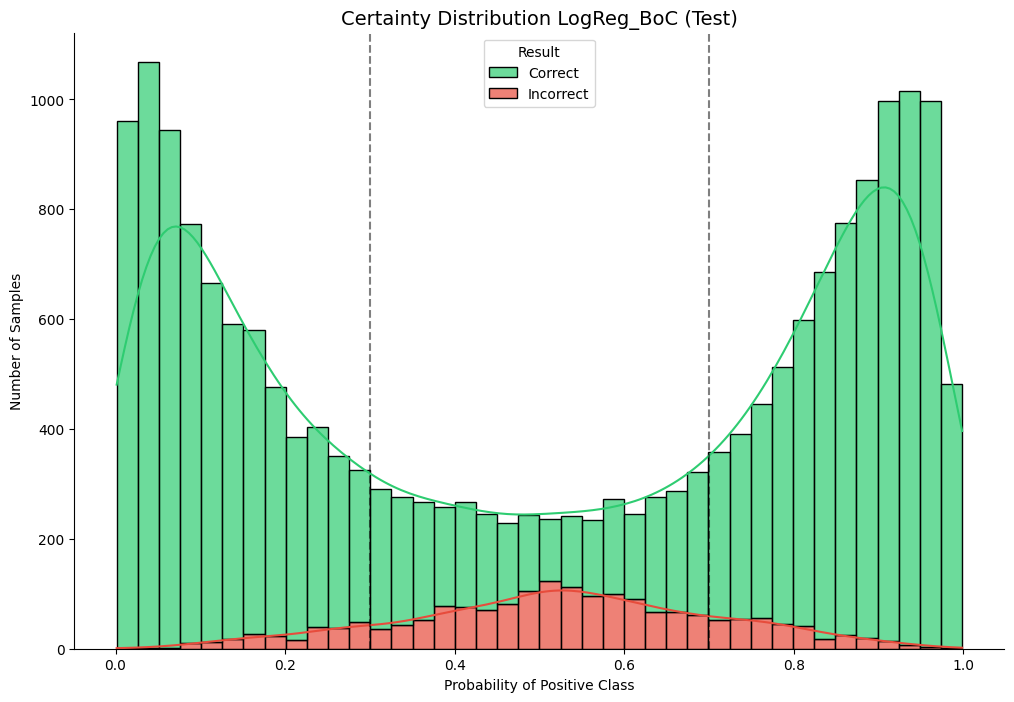

,Number_Samples,Correct,Accuracy (%),Coverage (%)
Overall,19833,18004,90.78,100.00
Certain Positive,8103,7769,95.88,40.86
Certain Negative,7519,7283,96.86,37.91
Uncertain,4211,2952,70.10,21.23


In [33]:
lr_model = LogisticRegressionClassifier(name="LogReg_BoC")
lr_model.train(X_train, [item['sentiment'] for item in train]) #
lr_probs_train, lr_preds_train = lr_model.evaluate(X_train, [item['sentiment'] for item in train], lower_threshold=LOWER_CONFIDENCE_THRESHOLD, name="Train")
lr_probs_test, lr_preds_test = lr_model.evaluate(X_test, [item['sentiment'] for item in test], lower_threshold=LOWER_CONFIDENCE_THRESHOLD, name="Test")

In [ ]:
bert_model = BERTClassifier(name="BERT_Base")
bert_model.train(
    X_text=[item['clean_review'] for item in train],
    y=[item['sentiment'] for item in train],
    epochs=3,
    batch_size=16
)

bert_model.save("data/bert_base")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060 Laptop GPU, compute capability 8.6


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060 Laptop GPU, compute capability 8.6
TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


Epoch 1/3


2026-01-04 14:04:25.162094: I external/local_xla/xla/service/service.cc:163] XLA service 0x7498341380e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-01-04 14:04:25.162454: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2026-01-04 14:04:25.201071: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-01-04 14:04:25.286922: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
I0000 00:00:1767531865.407256    4902 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


   1240/Unknown - 210s 156ms/step - loss: 0.3287 - accuracy: 0.8579

2026-01-04 14:07:40.619309: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2026-01-04 14:07:40.619362: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 15431669612423971997
2026-01-04 14:07:40.619368: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 5902809623009437387
2026-01-04 14:07:40.619375: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 18347047913279184918
2026-01-04 14:07:40.619387: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 1769424132675380014
2026-01-04 14:07:57.199221: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2026-01-04 14:07:57.199262: I tens

1240/1240 [==============================] - 228s 170ms/step - loss: 0.3287 - accuracy: 0.8579 - val_loss: 0.2929 - val_accuracy: 0.8738 - lr: 2.0000e-05
Epoch 2/3
1240/1240 [==============================] - 202s 162ms/step - loss: 0.2076 - accuracy: 0.9183 - val_loss: 0.3064 - val_accuracy: 0.8762 - lr: 2.0000e-05
Epoch 3/3
1240/1240 [==============================] - 210s 169ms/step - loss: 0.0997 - accuracy: 0.9634 - val_loss: 0.4036 - val_accuracy: 0.8768 - lr: 2.0000e-05


Identified 2050 low-confidence samples for refinement.


## BERT_BASE Evaluation (Uncertain SVM)

**Accuracy:** 0.7059

,precision,recall,f1-score,support
0,0.73712,0.66509,0.69925,1054
1,0.67880,0.74900,0.71217,996
accuracy,0.70585,0.70585,0.70585,0
macro avg,0.70796,0.70704,0.70571,2050
weighted avg,0.70878,0.70585,0.70553,2050


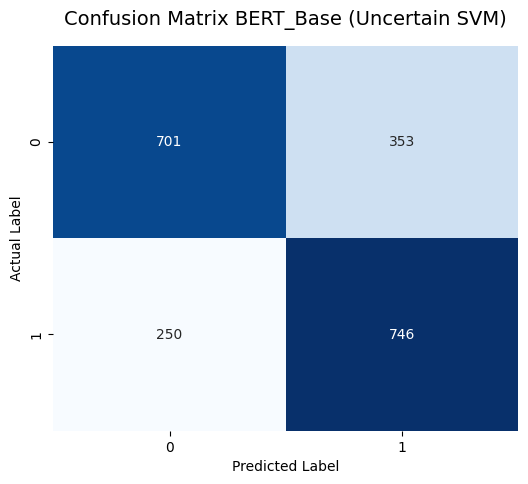

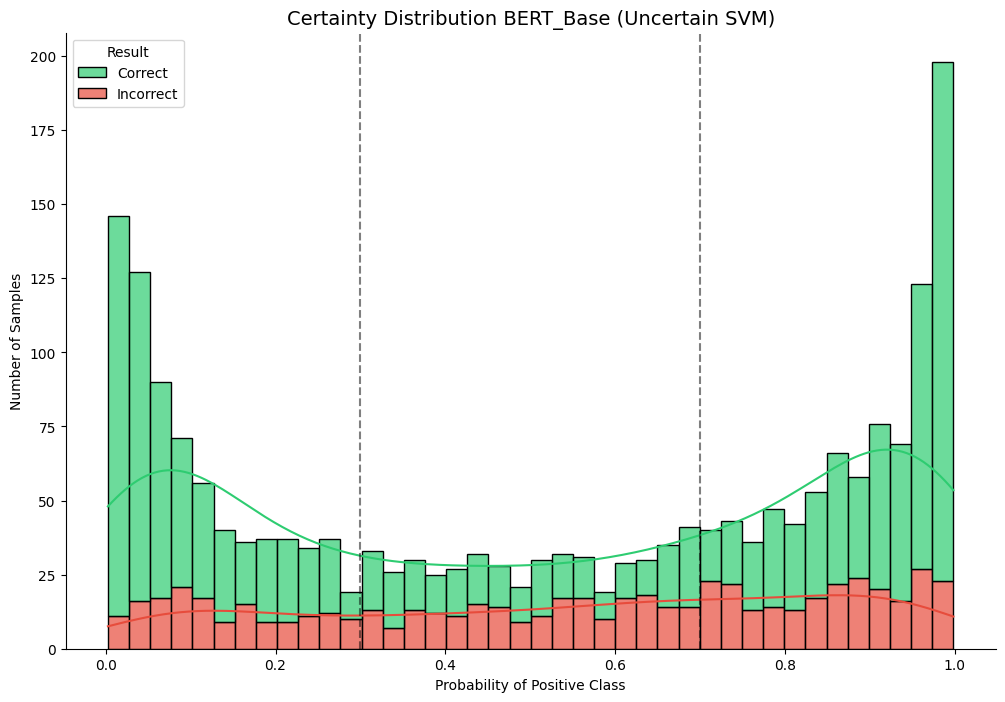

,Number_Samples,Correct,Accuracy (%),Coverage (%)
Overall,2050,1447,70.59,100.00
Certain Positive,848,617,72.76,41.37
Certain Negative,730,573,78.49,35.61
Uncertain,472,257,54.45,23.02


In [32]:
uncertain_mask = np.abs(svm_probs_test - 0.5) < 0.5 - LOWER_CONFIDENCE_THRESHOLD
test_low_conf = [test[i] for i, is_uncertain in enumerate(uncertain_mask) if is_uncertain]
print(f"Identified {len(test_low_conf)} low-confidence samples for refinement.")

# 1. Prepare data for BERT (Extracting from our filtered list of dictionaries)
X_refine = [item['clean_review'] for item in test_low_conf]
y_refine = [item['sentiment'] for item in test_low_conf]

# 2. Initial evaluation on these difficult samples before refinement
bert_prob_basic, bert_pred_basic = bert_model.evaluate(X_test=X_refine, y_test=y_refine, lower_threshold=LOWER_CONFIDENCE_THRESHOLD, name="Uncertain SVM")

In [37]:
print("Starting Stage 2: Targeted Refinement...")

bert_refined = BERTClassifier.load("data/bert_base")
bert_refined.name = "BERT_Refined"
bert_refined.freeze_backbone(num_layers_to_freeze=4) 

bert_refined.train(
    X_text=X_refine, 
    y=y_refine,
    epochs=10,
    batch_size=4,   # Small batch for difficult samples
    lr=5e-6         # Extremely low LR: $5 \times 10^{-6}$
)

bert_refined.save("data/bert_refined")

Starting Stage 2: Targeted Refinement...


Some layers from the model checkpoint at data/bert_base were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at data/bert_base and are newly initialized: ['dropout_59']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
    410/Unknown - 56s 113ms/step - loss: 0.5761 - accuracy: 0.7085

2026-01-04 14:31:27.621738: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 4265565447482869041
2026-01-04 14:31:27.621776: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 1611427967392186185
2026-01-04 14:31:27.621794: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 18241618988082142958
2026-01-04 14:31:27.621808: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 7501370455593139728
2026-01-04 14:31:33.420183: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 12800535334864771100
2026-01-04 14:31:33.420224: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15844453997499099260
2026-01-04 14:31:33.420241: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv 

410/410 [==============================] - 63s 130ms/step - loss: 0.5761 - accuracy: 0.7085 - val_loss: 0.5573 - val_accuracy: 0.7073 - lr: 5.0000e-06
Epoch 2/10
410/410 [==============================] - 39s 95ms/step - loss: 0.5500 - accuracy: 0.7116 - val_loss: 0.5523 - val_accuracy: 0.7146 - lr: 5.0000e-06
Epoch 3/10
410/410 [==============================] - 39s 95ms/step - loss: 0.5241 - accuracy: 0.7341 - val_loss: 0.5504 - val_accuracy: 0.7122 - lr: 5.0000e-06
Epoch 4/10
410/410 [==============================] - 39s 94ms/step - loss: 0.4903 - accuracy: 0.7616 - val_loss: 0.5619 - val_accuracy: 0.7195 - lr: 5.0000e-06
Epoch 5/10
410/410 [==============================] - 39s 94ms/step - loss: 0.4553 - accuracy: 0.7738 - val_loss: 0.5582 - val_accuracy: 0.7317 - lr: 5.0000e-06
Epoch 6/10
410/410 [==============================] - 39s 93ms/step - loss: 0.4189 - accuracy: 0.8116 - val_loss: 0.5737 - val_accuracy: 0.7146 - lr: 1.0000e-06


## BERT_REFINED Evaluation (Uncertain SVM)

**Accuracy:** 0.7532

,precision,recall,f1-score,support
0,0.77510,0.73245,0.75317,1054
1,0.73245,0.77510,0.75317,996
accuracy,0.75317,0.75317,0.75317,0
macro avg,0.75377,0.75377,0.75317,2050
weighted avg,0.75438,0.75317,0.75317,2050


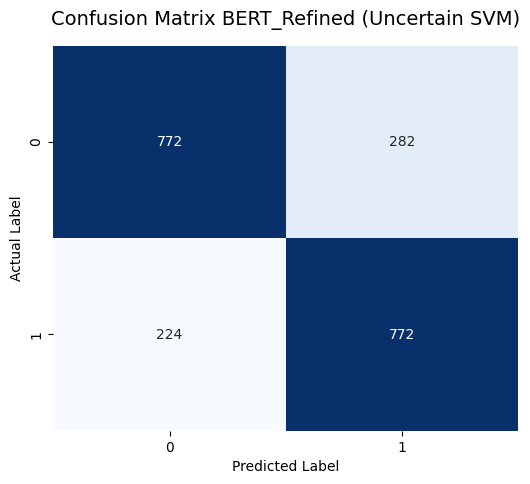

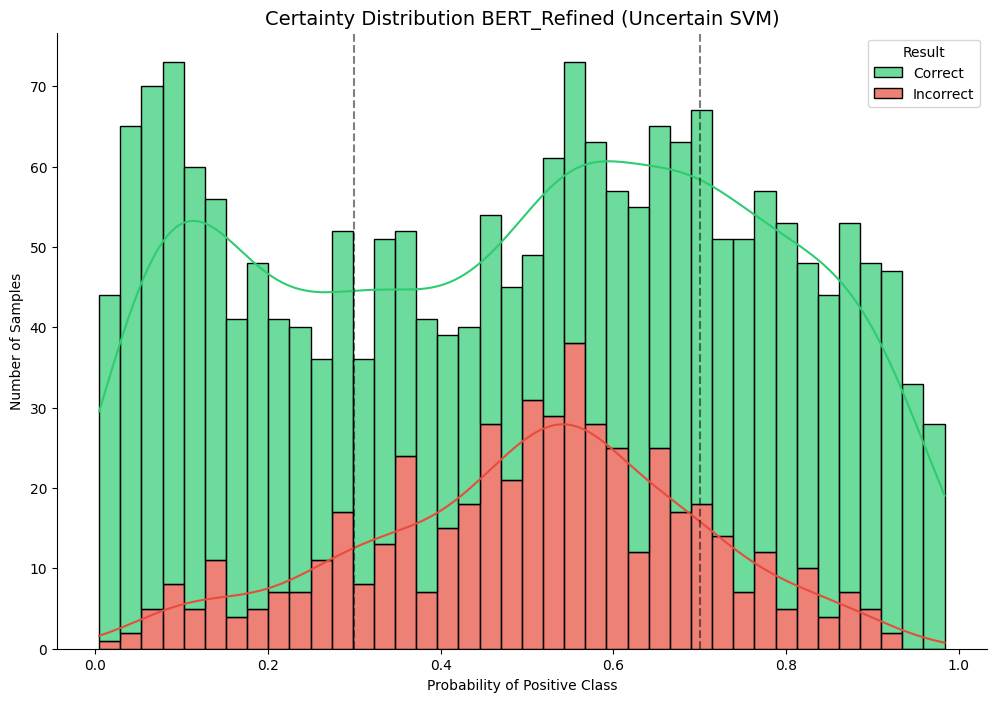

,Number_Samples,Correct,Accuracy (%),Coverage (%)
Overall,2050,1544,75.32,100.00
Certain Positive,554,480,86.64,27.02
Certain Negative,627,544,86.76,30.59
Uncertain,869,520,59.84,42.39



--- Top 5 'Confident' Positive Errors (Sure it was 1, actually 0) ---


/home/janek/Projekty/Sentiment/.venv/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,clean_review,sentiment,pred,prob
0,It's a good movie if you plan to watch lots of...,0,1,0.930176
1,I already know that critics and some audiences...,0,1,0.924316
2,This is an action Western. James Steart leads ...,0,1,0.908691
3,This is the sequel to Octopus. Pff... OK. A lo...,0,1,0.904785
4,"This is kind of a weird movie, given that Sant...",0,1,0.903320



--- Top 5 'Confident' Negative Errors (Sure it was 0, actually 1) ---


/home/janek/Projekty/Sentiment/.venv/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,clean_review,sentiment,pred,prob
0,Before seeing this picture I was quite skeptic...,1,0,0.061981
1,"Of course, by any normal standard of film crit...",1,0,0.057373
2,I swore I would never allow myself to devolve ...,1,0,0.044098
3,"By mistake, I ordered a series from the BBC, t...",1,0,0.030594
4,How could I possibly pass up the chance to see...,1,0,0.025833



--- Top 10 Most Uncertain Reviews (Prob near 0.5) ---


/home/janek/Projekty/Sentiment/.venv/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,clean_review,sentiment,pred,prob,uncertainty_score
0,I was quite impressed with this movie as a chi...,0,1,0.500488,0.000488
1,"One night, barkeeper Randy (Matt Dillon) rescu...",1,0,0.499268,0.000732
2,Yep. Those of my generation who grew up watchi...,0,1,0.500977,0.000977
3,"People call a 976 ""party line"" to talk dirty t...",0,1,0.501465,0.001465
4,"""They were always trying to get me killed,"" Al...",1,0,0.498047,0.001953
5,"""Two wildlife photographers are traveling thro...",0,1,0.503418,0.003418
6,I don't think the world was ready for this fil...,1,0,0.496338,0.003662
7,If you and your friends find as much humor and...,0,1,0.503906,0.003906
8,SPOILER ALERT!!!! This was my son's review of ...,1,0,0.495117,0.004883
9,I'm impressed that 'Hail the Woman' was made a...,1,0,0.495117,0.004883


In [38]:
bert_prob_refined, bert_pred_refined = bert_refined.evaluate(X_test=X_refine, y_test=y_refine, lower_threshold=LOWER_CONFIDENCE_THRESHOLD, name="Uncertain SVM")

for i, item in enumerate(test_low_conf):
    item['pred'] = bert_pred_refined[i]
    item['prob'] = bert_prob_refined[i]

ModelVisualizer.display_extreme_errors(test_low_conf)
ModelVisualizer.display_uncertain_errors(test_low_conf)

In [39]:
models_dict = {"coarse": svm_model, "fine": bert_refined}
X_sets_val = {"coarse": X_val, "fine": [item['clean_review'] for item in val]}

ensemble_0 = EnsembleClassifier(models_dict, threshold=1-LOWER_CONFIDENCE_THRESHOLD, name="Ensemble_SVM", weight=0)
ensemble_05 = EnsembleClassifier(models_dict, threshold=1-LOWER_CONFIDENCE_THRESHOLD, name="Ensemble_SVM_BERT_05", weight=0.5)
ensemble_07 = EnsembleClassifier(models_dict, threshold=1-LOWER_CONFIDENCE_THRESHOLD, name="Ensemble_SVM_BERT_07", weight=0.7)
ensemble_1 = EnsembleClassifier(models_dict, threshold=1-LOWER_CONFIDENCE_THRESHOLD, name="Ensemble_BERT", weight=1.0)

## ENSEMBLE_SVM Evaluation (Validation)

**Accuracy:** 0.9139

,precision,recall,f1-score,support
0,0.91813,0.90810,0.91309,2470
1,0.90974,0.91961,0.91465,2488
accuracy,0.91388,0.91388,0.91388,0
macro avg,0.91394,0.91386,0.91387,4958
weighted avg,0.91392,0.91388,0.91387,4958


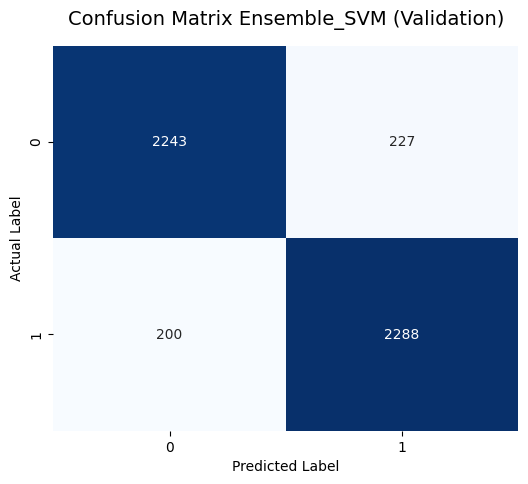

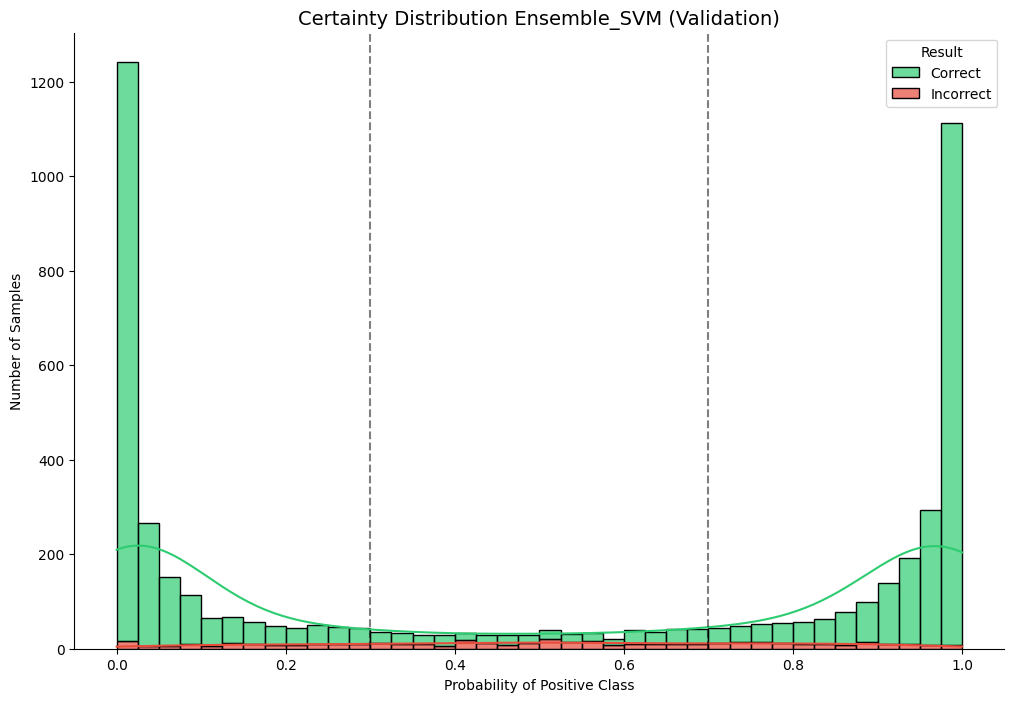

,Number_Samples,Correct,Accuracy (%),Coverage (%)
Overall,4958,4531,91.39,100.00
Certain Positive,2234,2103,94.14,45.06
Certain Negative,2197,2089,95.08,44.31
Uncertain,527,339,64.33,10.63


## ENSEMBLE_SVM_BERT_05 Evaluation (Validation)

**Accuracy:** 0.9252

,precision,recall,f1-score,support
0,0.92680,0.92267,0.92473,2470
1,0.92357,0.92765,0.92561,2488
accuracy,0.92517,0.92517,0.92517,0
macro avg,0.92518,0.92516,0.92517,4958
weighted avg,0.92518,0.92517,0.92517,4958


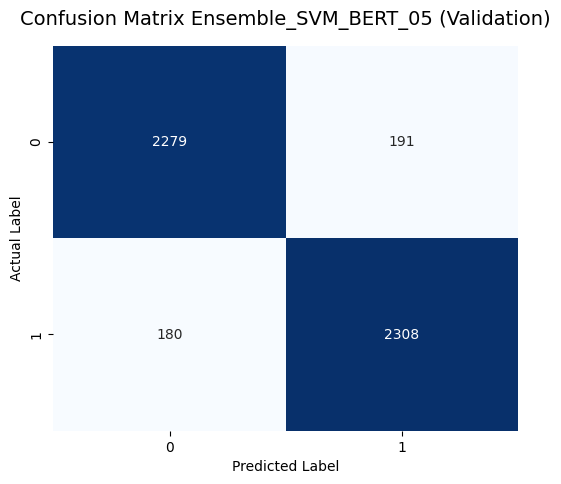

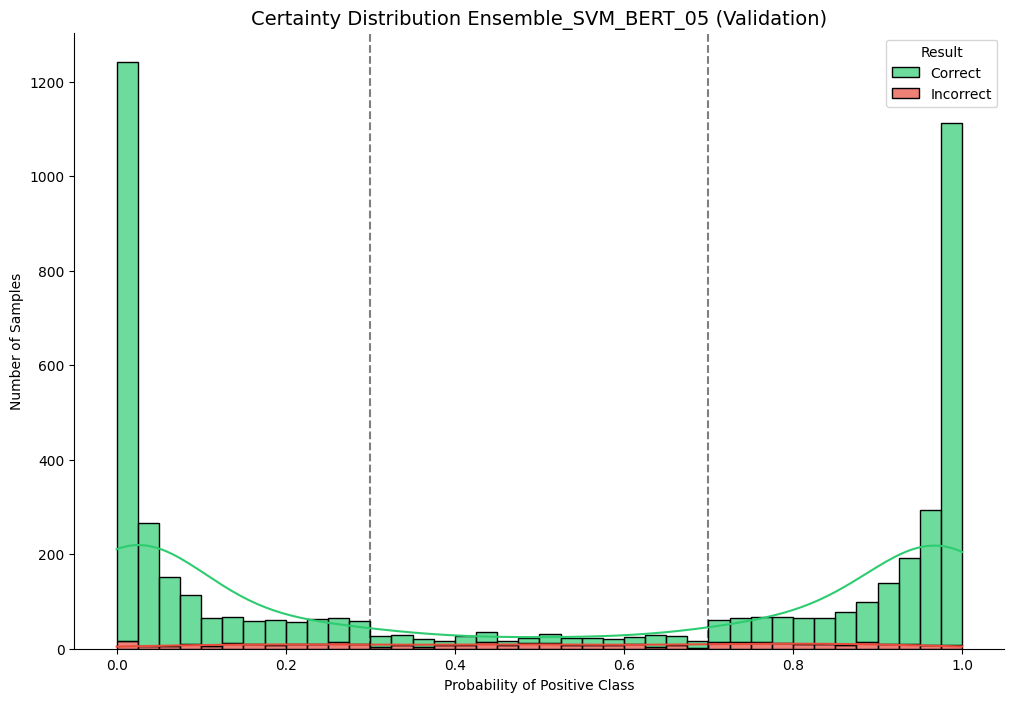

,Number_Samples,Correct,Accuracy (%),Coverage (%)
Overall,4958,4587,92.52,100.00
Certain Positive,2305,2170,94.14,46.49
Certain Negative,2268,2152,94.89,45.74
Uncertain,385,265,68.83,7.77


## ENSEMBLE_SVM_BERT_07 Evaluation (Validation)

**Accuracy:** 0.9244

,precision,recall,f1-score,support
0,0.92668,0.92105,0.92386,2470
1,0.92209,0.92765,0.92486,2488
accuracy,0.92436,0.92436,0.92436,0
macro avg,0.92439,0.92435,0.92436,4958
weighted avg,0.92438,0.92436,0.92436,4958


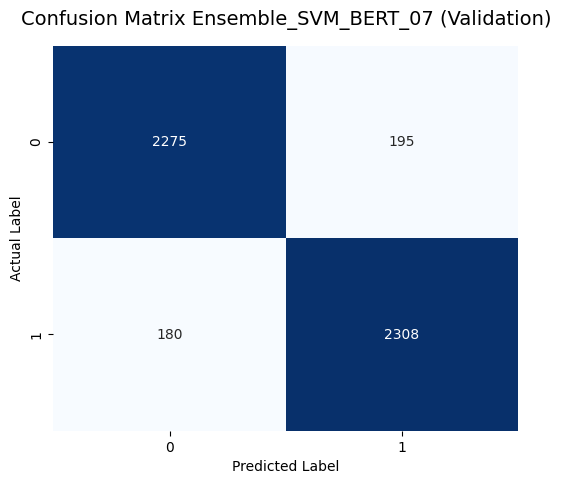

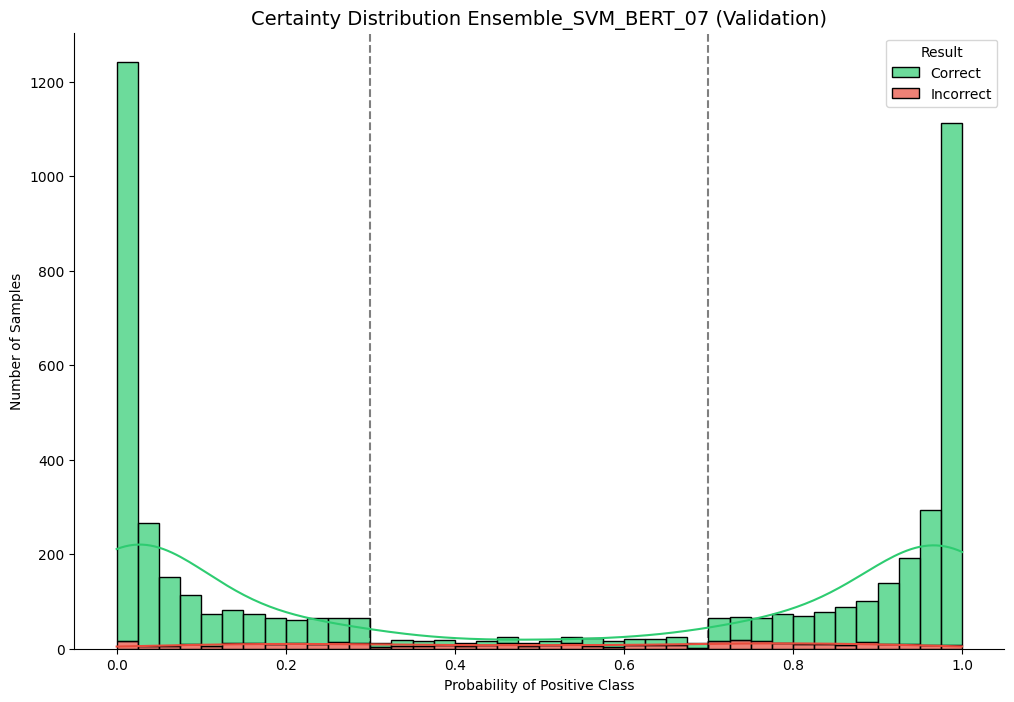

,Number_Samples,Correct,Accuracy (%),Coverage (%)
Overall,4958,4583,92.44,100.00
Certain Positive,2344,2203,93.98,47.28
Certain Negative,2323,2196,94.53,46.85
Uncertain,291,184,63.23,5.87


## ENSEMBLE_BERT Evaluation (Validation)

**Accuracy:** 0.9217

,precision,recall,f1-score,support
0,0.92490,0.91741,0.92114,2470
1,0.91866,0.92605,0.92234,2488
accuracy,0.92174,0.92174,0.92174,0
macro avg,0.92178,0.92173,0.92174,4958
weighted avg,0.92177,0.92174,0.92174,4958


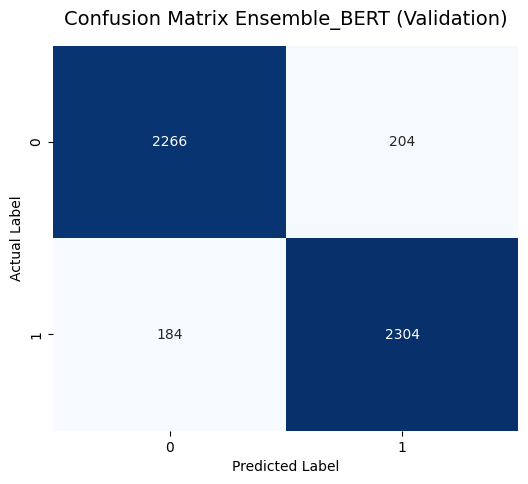

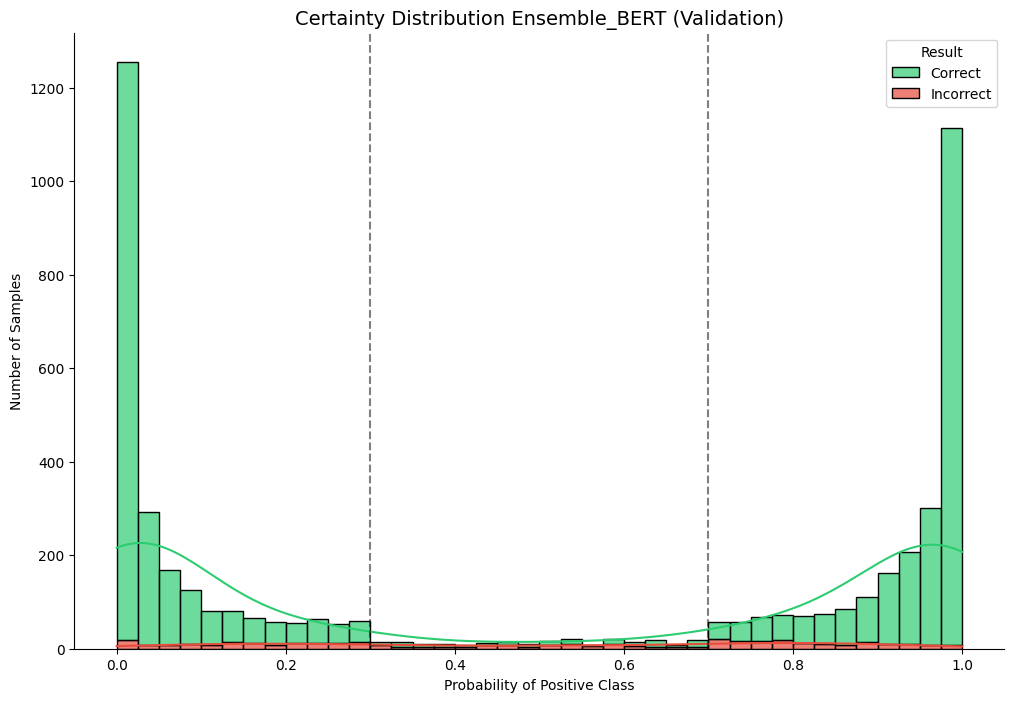

,Number_Samples,Correct,Accuracy (%),Coverage (%)
Overall,4958,4570,92.17,100.00
Certain Positive,2380,2225,93.49,48.00
Certain Negative,2356,2216,94.06,47.52
Uncertain,222,129,58.11,4.48


In [40]:
ensemble_models = [ensemble_0, ensemble_05, ensemble_07, ensemble_1]

for ensemble in ensemble_models:
    ensemble_probs, ensemble_preds = ensemble.evaluate(X_sets_val, [item['sentiment'] for item in val], lower_threshold=LOWER_CONFIDENCE_THRESHOLD, name="Validation")

In [41]:
for i, item in enumerate(val):
    item['pred'] = ensemble_preds[i]
    item['prob'] = ensemble_probs[i]

ModelVisualizer.display_extreme_errors(val)
ModelVisualizer.display_uncertain_errors(val)


--- Top 5 'Confident' Positive Errors (Sure it was 1, actually 0) ---


,clean_review,sentiment,pred,prob
0,I enjoyed the beautiful scenery in this movie ...,0,1,0.998858
1,The story goes something like this: A small-to...,0,1,0.998848
2,The one sheets and newspaper campaign suggeste...,0,1,0.998194
3,"This sleek, sexy movie is a must-see. Only upo...",0,1,0.996887
4,Don't get me wrong - I love David Suchet as Po...,0,1,0.990485



--- Top 5 'Confident' Negative Errors (Sure it was 0, actually 1) ---


,clean_review,sentiment,pred,prob
0,Unfortunately many consumers who write reviews...,1,0,0.010413
1,In defense of this movie I must repeat what I ...,1,0,0.007569
2,"Found this flick in a videostore, it cost $2 t...",1,0,0.006194
3,This would have worked a lot better if it had ...,1,0,0.005356
4,Was this based on a comic-book? A video-game? ...,1,0,0.004418



--- Top 10 Most Uncertain Reviews (Prob near 0.5) ---


,clean_review,sentiment,pred,prob,uncertainty_score
0,After watching KHAKEE i felt i'll get to watch...,0,1,0.500977,0.000977
1,25 sitcoms had big screen spin-offs. Most of t...,1,0,0.495605,0.004395
2,"You know the saying ""Curiosity Killed The Cat""...",1,0,0.494141,0.005859
3,"Ken Harrison, a young sculptor in his early th...",0,1,0.505859,0.005859
4,Meek and mild Edward G. Robinson (as Wilbert W...,0,1,0.511230,0.011230
5,While the new Pride & Prejudice film is gorgeo...,0,1,0.513672,0.013672
6,The film listed here as having been made in 19...,0,1,0.515137,0.015137
7,Having obtained a copy of Bostocks Cup I must ...,1,0,0.484375,0.015625
8,A thematic staple of cinema since its inceptio...,0,1,0.516113,0.016113
9,"Before this made for TV movie began, I had rel...",0,1,0.520996,0.020996


In [42]:
import numpy as np
import hashlib
from scipy.sparse import csr_matrix

def sparse_row_hashes_fast(X: csr_matrix):
    """
    Compute a hash for each row of a CSR sparse matrix efficiently.
    """
    hashes = np.empty(X.shape[0], dtype=np.int64)
    indptr = X.indptr
    indices = X.indices
    data = X.data

    # Safer version of the loop inside your function
    for i in range(X.shape[0]):
        m = hashlib.md5()
        # Feed index and data arrays directly to md5
        m.update(indices[indptr[i]:indptr[i+1]].tobytes())
        m.update(np.round(data[indptr[i]:indptr[i+1]], 8).tobytes())
        hashes[i] = int(m.hexdigest(), 16) % (2**63)
    return hashes

# 1. Compute hashes for all three sets
train_hashes = sparse_row_hashes_fast(X_train)
val_hashes = sparse_row_hashes_fast(X_val)
test_hashes = sparse_row_hashes_fast(X_test)

# 2. Define sets for fast intersection lookups
train_set = set(train_hashes)
val_set = set(val_hashes)
test_set = set(test_hashes)

# 3. Check for overlaps
overlaps = {
    "Train <-> Validation": len(train_set.intersection(val_set)),
    "Train <-> Test": len(train_set.intersection(test_set)),
    "Validation <-> Test": len(val_set.intersection(test_set))
}

print("--- Dataset Integrity Check ---")
for comparison, count in overlaps.items():
    status = "MIXED" if count > 0 else "CLEAN"
    print(f"{comparison}: {count} common rows - {status}")

if any(v > 0 for v in overlaps.values()):
    print("\nWARNING: Some reviews are present in multiple sets. "
          "This might be due to original dataset duplicates or a split error.")
else:
    print("\nSUCCESS: All datasets are mutually exclusive.")

--- Dataset Integrity Check ---
Train <-> Validation: 0 common rows - CLEAN
Train <-> Test: 2 common rows - MIXED
Validation <-> Test: 0 common rows - CLEAN

